In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [2]:
df = pd.read_csv('dinner_clean.csv')
df.head()

,link,Breakfast and Brunch,Dinners,Lunch,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100195/baked...,0,1,0,Baked Haddock,4.59,731,"['3/4 cup milk', '2 teaspoons salt', '3/4 cup ...",4.0,25,325.0,15.7,17.0,27.7,103.0,1565.0
1,https://www.allrecipes.com/recipe/100606/beef-...,0,1,0,Beef Bulgogi,4.79,664,"['1 pound flank steak, thinly sliced', '5 tabl...",4.0,75,232.0,13.2,12.4,16.2,27.0,1157.0
2,https://www.allrecipes.com/recipe/102159/apric...,0,1,0,Apricot Brown Sugar Ham,4.72,210,"['1 (10 pound) fully-cooked spiral cut ham', '...",15.0,120,801.0,56.2,14.4,56.1,170.0,3895.0
3,https://www.allrecipes.com/recipe/103503/taco-...,0,1,0,Taco Stuffed Shells,4.55,111,"['16 jumbo pasta shells', '1 pound ground beef...",8.0,80,361.0,17.6,30.4,19.8,60.0,957.0
4,https://www.allrecipes.com/recipe/103535/black...,0,1,0,Blackened Tuna Steaks With Mango Salsa,4.85,238,"['2 tablespoons olive oil', '2 tablespoons lim...",4.0,235,458.0,24.7,18.3,42.1,77.0,1233.0


In [3]:
df = df[['title', 'ingredients']]
df.head()

,title,ingredients
0,Baked Haddock,"['3/4 cup milk', '2 teaspoons salt', '3/4 cup ..."
1,Beef Bulgogi,"['1 pound flank steak, thinly sliced', '5 tabl..."
2,Apricot Brown Sugar Ham,"['1 (10 pound) fully-cooked spiral cut ham', '..."
3,Taco Stuffed Shells,"['16 jumbo pasta shells', '1 pound ground beef..."
4,Blackened Tuna Steaks With Mango Salsa,"['2 tablespoons olive oil', '2 tablespoons lim..."


In [4]:
# define a function to convert ingredients
def list_to_str(x):
    """
    Convert list to str
    """
    # extract list from str
    x = ast.literal_eval(x)
    
    # convert list to str
    x = ','.join(x)

    return x

In [5]:
# apply function to df
df.ingredients = df.ingredients.apply(list_to_str)
df.head()

,title,ingredients
0,Baked Haddock,"3/4 cup milk,2 teaspoons salt,3/4 cup bread cr..."
1,Beef Bulgogi,"1 pound flank steak, thinly sliced,5 tablespoo..."
2,Apricot Brown Sugar Ham,"1 (10 pound) fully-cooked spiral cut ham,2/3 c..."
3,Taco Stuffed Shells,"16 jumbo pasta shells,1 pound ground beef,1 (1..."
4,Blackened Tuna Steaks With Mango Salsa,"2 tablespoons olive oil,2 tablespoons lime jui..."


In [6]:
# create a new df with title as index
df_text = pd.DataFrame(df.ingredients.str.split(',').tolist(), index=df.title).stack()
df_text.head()

title           
Baked Haddock  0                       3/4 cup milk
               1                   2 teaspoons salt
               2               3/4 cup bread crumbs
               3     1/4 cup grated Parmesan cheese
               4    1/4 teaspoon ground dried thyme
dtype: object

In [7]:
# remove index
df_text = df_text.reset_index([0, 'title'])

# set column name
df_text.columns = ['title', 'ingredients']
df_text.head()

,title,ingredients
0,Baked Haddock,3/4 cup milk
1,Baked Haddock,2 teaspoons salt
2,Baked Haddock,3/4 cup bread crumbs
3,Baked Haddock,1/4 cup grated Parmesan cheese
4,Baked Haddock,1/4 teaspoon ground dried thyme


In [8]:
# define a function to clean ingredients
def clean_ingredients(x):
    """
    Clean ingredients
    """
    # remove punctuation and number
    x = re.sub(r'[^a-zA-Z]', ' ', x)
    
    # remove duplicate whitespace
    x = ' '.join(x.split())
    
    return x

In [9]:
# apply function to df
df_text.ingredients = df_text.ingredients.apply(clean_ingredients)
df_text.head()

,title,ingredients
0,Baked Haddock,cup milk
1,Baked Haddock,teaspoons salt
2,Baked Haddock,cup bread crumbs
3,Baked Haddock,cup grated Parmesan cheese
4,Baked Haddock,teaspoon ground dried thyme


In [10]:
# remove food or time units 
units = ['spoon','pound','cup','quart','ounce','pint','degree','dash','pinch','pack','halve','bunch']

for unit in units:
    expre = re.compile('\w*' + unit + '\w*')
    df_text.ingredients = df_text.ingredients.apply(lambda x: re.sub(expre, '', x).strip())
    
df_text.head()

,title,ingredients
0,Baked Haddock,milk
1,Baked Haddock,salt
2,Baked Haddock,bread crumbs
3,Baked Haddock,grated Parmesan cheese
4,Baked Haddock,ground dried thyme


In [11]:
# remove stopwords 
df_text.ingredients = df_text.ingredients.apply(lambda x: ' '.join([w.lower() for w in x.split(' ') if w.lower() not in stopwords.words('english')]))

In [12]:
# lemmatization
lemmatizer = WordNetLemmatizer()
df_text['ingredient'] = df_text.ingredients.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split(' ')]))

df_text.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread crumb
3,Baked Haddock,grated parmesan cheese,grated parmesan cheese
4,Baked Haddock,ground dried thyme,ground dried thyme


In [13]:
# remove recipe stopwords
recipe_stopwords = ['grated','ground','dried','fillet','melted','thinly','sliced','chopped','minced','fully','cooked',
                    'cut','dry','shredded','divided','optional','minced','fresh','peeled','pitted','finely','wedge',
                    'coarsely','e g','flaked','zested','low','canned','sodium','large','whole','scored','serving',
                    'piece','plus','soaked','inch','untreated','removed','diced','juiced','stemmed','cracked',
                    'coarse','fine','slice','beaten','mix','mixed','part','skim','crushed','clove','can','frozen',
                    'thawed','nonfat','container','lean','recipe','dish','scrubbed','all','purpose','thick','stalk',
                    'kosher','cored','milliliter','bottle','style','distilled','chop','drained','cubed','cube','pre',
                    'fluid','flavored','medium','jumbo','taste','blanched','crumbled','crumb','seasoned','boneless',
                    'thin','carton','substitute','dipping','homemade','hour','pushed','washed','small','gallon',
                    'refried','favorite','split','lightly','prepared','leaf','toasted','except','eat','rinsed','bite',
                    'size','color','baby','trimmed','cluster','box','quick','cooking','ripe','reduced','fat',
                    'refrigerated','pan','regular','healthy','free','pouch','chuck','mashed','layer','marinated',
                    'imported','room temperature','top','freshly','boiled','rub']

In [14]:
# remove recipe stopwords
df_text.ingredient = df_text.ingredient.apply(lambda x: ' '.join([w.lower() for w in x.split(' ') 
                                                                if w.lower() not in recipe_stopwords]))

In [15]:
# keep the rows with ingred
df_text = df_text[df_text.ingredient != '']

In [158]:
df_text.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread
3,Baked Haddock,grated parmesan cheese,parmesan cheese
4,Baked Haddock,ground dried thyme,thyme


In [162]:
df_text.set_index('title', inplace=True)
df_text.head()

,ingredients,ingredient
title,,
Baked Haddock,milk,milk
Baked Haddock,salt,salt
Baked Haddock,bread crumbs,bread
Baked Haddock,grated parmesan cheese,parmesan cheese
Baked Haddock,ground dried thyme,thyme


In [163]:
# save df
df_text.to_csv('dinner_text.csv')

In [16]:
# check recipe vocabulary
vocab = dict()
for i in range(df_text.shape[0]):
    word = df_text.ingredient.iloc[i]
    if word not in vocab.keys():
        vocab[word] = 1
    else:
        vocab[word] += 1

In [17]:
# check total num of ingredients
len(list(vocab.keys()))

1640

In [47]:
# create a df with word counts
df_count = pd.DataFrame(vocab, index=['count']).transpose().sort_values('count', ascending=False)
df_count = df_count.reset_index().rename(columns={'index': 'ingredient'})
df_count.head()

,ingredient,count
0,salt,540
1,garlic,449
2,black pepper,360
3,olive oil,314
4,onion,290


In [57]:
# plot the most common ingredients
def plot_ingredient(df, top_n=10, figsize=(8,10)):
    plt.figure(figsize=figsize)
    
    count = df['count'].iloc[:top_n]
    ingred = df['ingredient'].iloc[:top_n]
    sns.barplot(x=count, y=ingred, palette='Reds_r')
    plt.title(f'{top_n} most common ingredients\n')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.show()

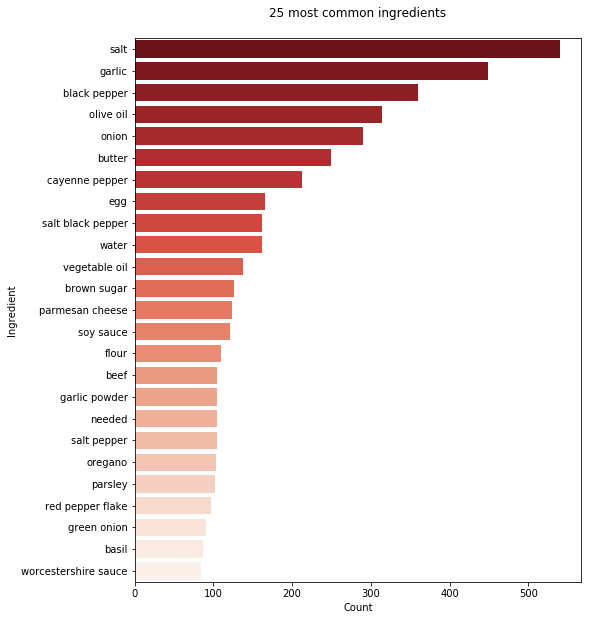

In [58]:
plot_ingredient(df_count, top_n=25)

# Topic Modeling

## LDA using sklearn

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [239]:
# combine ingred into one
df_lda = df_text.groupby('title')['ingredient'].apply(' '.join).reset_index()
df_lda.head()

,title,ingredient
0,A Scotsmans Shepherd Pie,boiled potato sour cream cream cheese butter s...
1,A Simply Perfect Roast Turkey,turkey unsalted butter softened salt black pep...
2,Absolute Best Liver And Onions,beef liver milk needed butter vidalia onion ri...
3,Accidental Fish,mahi mahi olive oil salted butter garlic lemon...
4,Actually Delicious Turkey Burgers,turkey bread onion egg white parsley garlic sa...


In [108]:
# initialize tfidf 
vec = CountVectorizer()
vec_matrix = vec.fit_transform(df_lda.ingredient)

In [109]:
vec_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [110]:
# initialize and fit LDA 
lda = LDA(n_components=10)
lda.fit(vec_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [111]:
lda_matrix = lda.transform(vec_matrix)

In [112]:
lda_matrix

array([[0.53957212, 0.25359468, 0.00243947, ..., 0.00243967, 0.00243938,
        0.0024397 ],
       [0.5280268 , 0.39923994, 0.00909147, ..., 0.00909192, 0.00909228,
        0.00909118],
       [0.72890297, 0.00769442, 0.00769393, ..., 0.2095462 , 0.00769494,
        0.00769428],
       ...,
       [0.00454636, 0.31004958, 0.06760341, ..., 0.47265835, 0.0045463 ,
        0.00454681],
       [0.50061835, 0.08241442, 0.00312562, ..., 0.00312605, 0.00312579,
        0.32773357],
       [0.00833699, 0.00833602, 0.00833896, ..., 0.00833472, 0.00833776,
        0.00833422]])

In [113]:
def print_topics(lda, vectorizer, top_n):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-top_n - 1:-1]]))

In [115]:
print("Topics found via LDA:")
print_topics(lda, vec, 20)

Topics found via LDA:

Topic #0:
pepper salt black onion oil garlic beef water butter cayenne broth sauce olive red tomato vegetable needed rosemary celery bay

Topic #1:
pepper butter salt cheese garlic parsley olive oil lemon black cream parmesan deveined shrimp heavy white italian onion egg wine

Topic #2:
pepper chicken cumin broth powder flour lime chipotle chili beef tortilla dressing corn black onion salt vegetable roast cilantro breast

Topic #3:
cheese tomato garlic onion pepper sauce parmesan salt mozzarella egg black pasta jar beef olive basil cream oil oregano italian

Topic #4:
salt pepper mustard pork black dijon sauce vinegar powder garlic roast sugar brown apple cider rib barbeque shoulder cayenne worcestershire

Topic #5:
sauce soy oil rice sesame green garlic vinegar hot onion white sugar paste pepper vegetable seed ginger asian wine brown

Topic #6:
sauce sugar brown pepper soy garlic ginger vegetable onion powder oil white pork water root ketchup salt vinegar beef j

In [116]:
columns = []
for i in range(1, 11):
    columns.append('topic_' + str(i))

In [117]:
# create a new df
df_topic = pd.DataFrame(lda_matrix, index=df_lda.title.tolist(), columns=columns)

In [124]:
df_topic.topic_1.sort_values(ascending=False)[:20]
# topic_1 looks more like Meat dish

Chef Johns Cassoulet                                         0.985481
How To Make Cassoulet                                        0.982349
Chef Johns Face Pie                                          0.980846
Tourtiere French Canadian Meat Pie                           0.979540
Dirty Dirty Rice                                             0.976309
Short Rib And Cauliflower Curry                              0.972717
Chef Johns Roast Turkey And Gravy                            0.970965
Peppercorn Roast Beef                                        0.970962
Beef Bourguignon I                                           0.968959
Cotechino And Braised Beans                                  0.968959
Sous Vide New York Strip Steak                               0.967852
Midwest Salisbury Steak                                      0.966659
Lamb Meatballs And Sauce                                     0.966659
Instant Pot Salisbury Steak With Onion And Mushroom Gravy    0.966657
Coconut Milk Corned 

In [126]:
df_topic.topic_2.sort_values(ascending=False)[:20]
# topic_2 looks more like Seafood dish

Shrimp Scampi With Pasta                                0.969996
Cajun Seafood Pasta                                     0.965379
Exchange Gang Pasta With Shrimp                         0.963995
Gourmet Mushroom Risotto                                0.959081
Ultimate Shrimp Scampi                                  0.959080
Chef Johns Prison Style Meatloaf                        0.959079
Shrimp Lemon Pepper Linguini                            0.957136
Grilled Pattypan Squash With Hot Chorizo Vinaigrette    0.957130
Spaghetti With Clam Sauce                               0.954993
Lobster Newberg                                         0.952628
Almond Crusted Tilapia                                  0.952623
Shrimp And Asparagus                                    0.952622
Instant Mac And Cheese                                  0.952620
Fish Roll Ups                                           0.949989
Shrimp Linguine                                         0.947053
Ham And Cheese Quiche    

In [128]:
df_topic.topic_3.sort_values(ascending=False)[:20]
# topic_3 looks more like Mexican cuisine

Kris Amazing Shredded Mexican Beef                             0.962490
Slow Cooker Pinto Beans                                        0.954989
Mississippi Pot Roast                                          0.952627
Slow Cooker Pot Roast                                          0.949990
Original Homemade Italian Beef                                 0.924987
Ronaldos Beef Carnitas                                         0.918158
Slow Cooker Italian Beef                                       0.909991
Blat Wraps                                                     0.909983
Mississippi Roast   Slow Cooker Pepperoncini Pot Roast         0.909982
Honey Glazed Ham                                               0.887460
Chicken And Mushroom Chimichangas                              0.827063
Three Packet Slow Cooker Roast                                 0.792376
Pork Carnitas                                                  0.640828
Chipotle Shrimp Tacos                                          0

In [129]:
df_topic.topic_4.sort_values(ascending=False)[:20]
# topic_4 looks more like Italian cuisine

Alysias Basic Meat Lasagna                 0.967851
Spinach Lasagna Iii                        0.965379
Pizza Without The Red Sauce                0.962491
Hearty Vegetable Lasagna                   0.959084
Spinach And Feta Pita Bake                 0.957138
Spinach Cheese Manicotti                   0.957137
Four Cheese Margherita Pizza               0.954993
Spinach Lasagna Ii                         0.952626
Jalapeno Popper Grilled Cheese Sandwich    0.952619
Three Cheese Manicotti                     0.949995
Stuffed Shells Iii                         0.949994
Taco Stuffed Shells                        0.949991
Lasagna Roll Ups                           0.947056
Baked Ziti Iii                             0.947055
Manicotti                                  0.947052
Spaghetti Squash Casserole In The Shell    0.947048
Baked Ziti I                               0.943746
Three Cheese Baked Pasta                   0.943746
Three Cheese Manicotti Ii                  0.939996
Bats And Cob

In [130]:
df_topic.topic_5.sort_values(ascending=False)[:20]
# topic_5 looks more like Pork dish

Chef Johns Pumpkin Braised Pork                  0.962489
Bourbon Mango Pulled Pork                        0.960863
Southern Grilled Barbecued Ribs                  0.959081
Herbed Pork And Apples                           0.959081
Slow Cooker Carolina Bbq                         0.957135
Pork Chops With Apple Cider Glaze                0.957133
Barbecued Beef                                   0.954993
Quick Savory Cranberry Glazed Pork Loin Roast    0.954991
Apple Cider Sauce And Pork Loin Chops            0.954988
Maple Glazed Ribs                                0.943745
Spoiled Baby Back Ribs                           0.943745
Barbeque Pork Two Ways                           0.935701
Simple Bbq Ribs                                  0.918171
Kalua Pig In A Slow Cooker                       0.909995
Prime Rib                                        0.909991
Simple Savory Pork Roast                         0.909990
Grilled Pork Tenderloin                          0.909986
Salmon With Br

In [131]:
df_topic.topic_6.sort_values(ascending=False)[:20]
# topic_6 looks more like Korean cuisine

Grilled Korean Style Beef Short Ribs             0.967854
Korean Bbq Short Ribs Gal Bi                     0.962493
Kalbi Korean Bbq Short Ribs                      0.952625
Awesome Korean Steak                             0.949996
Miso Maple Glazed Salmon                         0.947051
Sesame Beef                                      0.935705
Spicy Eggplant                                   0.896391
Korean Bbq Beef Pul Kogi                         0.829929
Easy Korean Ground Beef Bowl                     0.757585
Beef Bulgogi                                     0.732876
Korean Barbecued Rack Of Lamb                    0.731522
Lovers Beef Burgundy Filet                       0.728278
Halibut With Rice Wine                           0.721038
Root Beer And Sesame Glazed Ribs                 0.687187
Grilled Hoisin Beef                              0.676100
Corned Beef Kimchi Fried Rice                    0.663486
Spicy Pork And Vegetable Tofu                    0.662166
Chef Johns Chi

In [132]:
df_topic.topic_7.sort_values(ascending=False)[:20]
# topic_7 looks more like Asian cuisine

Penang Pork Satay                      0.976918
How To Make Beef Satay                 0.965380
Thai Dipped Beef Tri Tip               0.965378
Cocoa Cherry Pork                      0.959081
Chinese Pepper Steak                   0.954989
Sylvias Ribs                           0.952623
Braised Corned Beef Brisket            0.939987
Marinated Turkey Breast                0.939984
Pineapple Grilled Pork Chops           0.935702
Grilled Salmon I                       0.935700
Chipotle Crusted Pork Tenderloin       0.930756
Honey Ginger Grilled Salmon            0.924986
Jewish Style Sweet And Sour Brisket    0.924984
Marinated Pork Tenderloin              0.843517
Ginger Glazed Mahi Mahi                0.825313
Pork Dumplings                         0.793157
Chile Garlic Bbq Salmon                0.787637
Glazed Corned Beef                     0.784809
Barbecue Ribs                          0.782857
Barbequed Marinated Flank Steak        0.782572
Name: topic_7, dtype: float64

In [134]:
df_topic.topic_8.sort_values(ascending=False)[:20]
# topic_8 looks more like Fish dish

Chef Johns Pasta Con Le Sarde                  0.968959
Veracruz Style Red Snapper                     0.967854
Fennel Smoked Salmon                           0.959081
Pattis Mussels A La Mariniere                  0.954993
Blackened Salmon Fillets                       0.952622
Cajun Style Blackened Snapper                  0.949991
Rocks T Bone Steaks                            0.947049
Blackened Tuna Steaks With Mango Salsa         0.940242
Simple Broiled Haddock                         0.939989
Seasoned Swai Fish Fillet                      0.939989
Baked Salmon Ii                                0.930760
Capers And Halibut                             0.930757
Jalapeno Steak                                 0.924991
Grilled Fish Steaks                            0.924990
Grilled Halibut With Cilantro Garlic Butter    0.924989
Pan Seared Salmon I                            0.899989
Super Simple Salmon                            0.887474
Swordfish A La Siciliana                       0

In [135]:
df_topic.topic_9.sort_values(ascending=False)[:20]
# topic_9 looks more like Starch dish

How To Make Turkey Manicotti           0.979067
Chicago Deep Dish Pizza                0.976921
Chef Johns Spaghetti Alla Carbonara    0.963995
Crispy Beer Batter Fish Chips          0.957132
One Pan Orecchiette Pasta              0.952615
Bread Machine Calzone                  0.949992
Chef Johns Pourable Pizza              0.939988
Chef Johns Potato Gnocchi              0.930760
Easy French Dip Sandwiches             0.924971
Crust For Veggie Pot Pie               0.849980
Sicilian Christmas Pizza Sfincione     0.834940
Calzone                                0.810287
Torta Di Riso                          0.674146
Chef Johns Ham And Cheese Calzones     0.644887
Roman Style Gnocchi                    0.632561
Easiest Slow Cooker French Dip         0.622107
Garlic Noodles                         0.605273
Chef Johns Sausage And Egg Pizza       0.604916
Kraut Bierocks                         0.588131
Rolled Dumplings                       0.580897
Name: topic_9, dtype: float64

In [136]:
df_topic.topic_10.sort_values(ascending=False)[:20]
# topic_10 looks more like Ground Meat dish

Bbq Glazed Homemade Meatballs                 0.957134
German Rouladen                               0.939986
Pork Apple Burgers                            0.935704
Tantalizingly Tangy Meatloaf                  0.930761
Reuben Sandwich Ii                            0.930761
Classic Cuban Midnight Medianoche Sandwich    0.930758
Mini Meatloaves                               0.924990
Easy Meatloaf                                 0.924985
Sausage And Sauerkraut                        0.918171
Glazed Baked Ham                              0.819999
Island Style Fried Rice                       0.746896
Brisket With Bbq Sauce                        0.738007
Melt In Your Mouth Meat Loaf                  0.727431
Easy Oven Brown Rice                          0.712834
Reuben Sandwich                               0.709678
Big Smokey Burgers                            0.701776
Glazed Meatloaf Ii                            0.654761
Best Ever Meat Loaf                           0.651080
Beths Meat

In [137]:
df_topic.columns = ['Meat','Seafood','Mexican','Italian','Pork',
                    'Korean','Asian','Fish','Starch','Ground_meat']
df_topic.head(1)

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.00244,0.00244,0.002439,0.00244


In [138]:
df_topic.to_csv('dinner_cluster.csv')

In [140]:
df_tag = df_topic.copy()

In [155]:
df_tag['cluster'] = 0
df_tag.head()

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat,cluster
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.002440,0.002440,0.002439,0.002440,0
A Simply Perfect Roast Turkey,0.528027,0.399240,0.009091,0.009092,0.009092,0.009091,0.009092,0.009092,0.009092,0.009091,0
Absolute Best Liver And Onions,0.728903,0.007694,0.007694,0.007693,0.007693,0.007693,0.007694,0.209546,0.007695,0.007694,0
Accidental Fish,0.005264,0.005264,0.005264,0.005264,0.005264,0.005265,0.005265,0.569317,0.005264,0.388570,0
Actually Delicious Turkey Burgers,0.009094,0.918164,0.009092,0.009093,0.009092,0.009092,0.009093,0.009093,0.009092,0.009093,0


In [200]:
for i in range(df_tag.shape[0]):
    max_value = df_tag.iloc[i].max()
    max_tag = df_tag.iloc[i][df_tag.iloc[i] == max_value].index[0]
    df_tag.cluster.iloc[i] = max_tag

In [202]:
df_cluster = pd.read_csv('dinner_cluster.csv')
df_cluster = df_cluster.rename(columns={'Unnamed: 0': 'title'}).set_index('title')
df_cluster.head()

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat
title,,,,,,,,,,
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.002440,0.002440,0.002439,0.002440
A Simply Perfect Roast Turkey,0.528027,0.399240,0.009091,0.009092,0.009092,0.009091,0.009092,0.009092,0.009092,0.009091
Absolute Best Liver And Onions,0.728903,0.007694,0.007694,0.007693,0.007693,0.007693,0.007694,0.209546,0.007695,0.007694
Accidental Fish,0.005264,0.005264,0.005264,0.005264,0.005264,0.005265,0.005265,0.569317,0.005264,0.388570
Actually Delicious Turkey Burgers,0.009094,0.918164,0.009092,0.009093,0.009092,0.009092,0.009093,0.009093,0.009092,0.009093


In [230]:
df_cluster.Asian[df_cluster.Asian >= 0.7].shape

(25,)

In [231]:
# randomly choose 3 most relevant recipes from each topic to show as a choice
choose_recipe = []
for topic in df_cluster.columns.tolist():
    dish_ls = df_cluster.Meat[df_cluster.Meat >= 0.7].index.tolist()
    recipe_ls = np.random.choice(dish_ls, 3).tolist()
    choose_recipe.extend(recipe_ls)

In [233]:
len(choose_recipe)

30

## LDA using gensim

In [284]:
from pprint import pprint
import tqdm
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [238]:
df_text = pd.read_csv('dinner_text.csv')
df_text.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread
3,Baked Haddock,grated parmesan cheese,parmesan cheese
4,Baked Haddock,ground dried thyme,thyme


In [242]:
# combine ingred into one
df_lda = df_text.groupby('title')['ingredient'].apply(' '.join).reset_index()
df_lda.head()

,title,ingredient
0,A Scotsmans Shepherd Pie,boiled potato sour cream cream cheese butter s...
1,A Simply Perfect Roast Turkey,turkey unsalted butter softened salt black pep...
2,Absolute Best Liver And Onions,beef liver milk needed butter vidalia onion ri...
3,Accidental Fish,mahi mahi olive oil salted butter garlic lemon...
4,Actually Delicious Turkey Burgers,turkey bread onion egg white parsley garlic sa...


In [259]:
# define a function tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # remove punctuations
        
data_text = df_lda.ingredient.values.tolist()
data_words = list(sent_to_words(text)) 

In [452]:
data_words[0] # each list is a recipe

['boiled',
 'potato',
 'sour',
 'cream',
 'cream',
 'cheese',
 'butter',
 'softened',
 'egg',
 'yolk',
 'salt',
 'black',
 'pepper',
 'olive',
 'oil',
 'lamb',
 'salt',
 'black',
 'pepper',
 'stewed',
 'tomato',
 'juice',
 'onion',
 'carrot',
 'pea',
 'irish',
 'stout',
 'beer',
 'guinness',
 'beef',
 'bouillon',
 'flour',
 'worcestershire',
 'sauce',
 'sharp',
 'cheddar',
 'cheese',
 'parsley',
 'smoked',
 'paprika']

In [261]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [263]:
# define functions for bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [267]:
data_bigrams = make_bigrams(data_words)

In [272]:
# create Dictionary
id2word = corpora.Dictionary(data_bigrams)

In [273]:
# create corpus
texts = data_bigrams

In [275]:
# term doc frequency - mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in texts]

In [277]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100, # how many docs are processed at a time in the training algorithm
                                       passes=10, # how often we train the model on the entire corpus
                                       per_word_topics=True)

In [279]:
# Print the keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"salt" + 0.060*"pepper" + 0.056*"flour" + 0.054*"butter" + '
  '0.038*"turkey" + 0.036*"milk" + 0.033*"garlic" + 0.029*"parsley" + '
  '0.028*"egg" + 0.025*"bread"'),
 (1,
  '0.101*"pepper" + 0.052*"salt" + 0.047*"oil" + 0.040*"black" + 0.039*"olive" '
  '+ 0.037*"garlic" + 0.029*"cayenne" + 0.026*"rosemary" + 0.026*"cumin" + '
  '0.023*"paprika"'),
 (2,
  '0.130*"cheese" + 0.039*"tomato" + 0.039*"sauce" + 0.037*"pepper" + '
  '0.035*"salt" + 0.035*"egg" + 0.032*"parmesan" + 0.028*"garlic" + '
  '0.027*"oil" + 0.026*"olive"'),
 (3,
  '0.069*"pepper" + 0.054*"salt" + 0.046*"black" + 0.033*"oil" + '
  '0.029*"garlic" + 0.026*"mustard" + 0.023*"butter" + 0.023*"dijon" + '
  '0.019*"cayenne" + 0.018*"pork"'),
 (4,
  '0.075*"turkey" + 0.068*"onion" + 0.052*"pepper" + 0.032*"chicken" + '
  '0.029*"salt" + 0.029*"beef" + 0.027*"green" + 0.025*"flake" + 0.024*"short" '
  '+ 0.023*"bay"'),
 (5,
  '0.090*"sauce" + 0.055*"pepper" + 0.046*"sugar" + 0.036*"garlic" + '
  '0.035*"brown"

In [332]:
# calculate baseline Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 2))

Coherence Score:  0.43


In [352]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [354]:
grid = {}
grid['Validation_Set'] = {}

# topics range
topics_range = range(2, 11, 1)

# alpha parameter
alpha = [0.01, 0.1, 1, 'symmetric', 'asymmetric']

# beta parameter
beta = [0.01, 0.1, 1, 'symmetric']

# validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus[:int(num_of_docs*0.75)], corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

In [355]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()





  0%|          | 0/540 [00:00<?, ?it/s]



  0%|          | 1/540 [00:01<17:05,  1.90s/it]



  0%|          | 2/540 [00:03<17:16,  1.93s/it]



  1%|          | 3/540 [00:05<17:11,  1.92s/it]



  1%|          | 4/540 [00:07<17:25,  1.95s/it]



  1%|          | 5/540 [00:09<17:16,  1.94s/it]



  1%|          | 6/540 [00:11<17:24,  1.96s/it]



  1%|▏         | 7/540 [00:13<17:45,  2.00s/it]



  1%|▏         | 8/540 [00:15<17:41,  2.00s/it]



  2%|▏         | 9/540 [00:18<18:32,  2.09s/it]



  2%|▏         | 10/540 [00:20<19:55,  2.26s/it]



  2%|▏         | 11/540 [00:23<20:38,  2.34s/it]



  2%|▏         | 12/540 [00:25<21:20,  2.43s/it]



  2%|▏         | 13/540 [00:28<22:02,  2.51s/it]



  3%|▎         | 14/540 [00:31<22:00,  2.51s/it]



  3%|▎         | 15/540 [00:34<22:54,  2.62s/it]



  3%|▎         | 16/540 [00:36<23:03,  2.64s/it]



  3%|▎         | 17/540 [00:39<22:25,  2.57s/it]



  3%|▎         | 18/540 [00:41<22:16,  2.56s/it]



  4%|▎         | 19/540 [0

 24%|██▎       | 127/540 [05:27<19:06,  2.78s/it]



 24%|██▎       | 128/540 [05:29<18:41,  2.72s/it]



 24%|██▍       | 129/540 [05:32<18:02,  2.63s/it]



 24%|██▍       | 130/540 [05:34<17:25,  2.55s/it]



 24%|██▍       | 131/540 [05:37<17:19,  2.54s/it]



 24%|██▍       | 132/540 [05:39<17:02,  2.51s/it]



 25%|██▍       | 133/540 [05:42<17:13,  2.54s/it]



 25%|██▍       | 134/540 [05:44<17:06,  2.53s/it]



 25%|██▌       | 135/540 [05:47<17:27,  2.59s/it]



 25%|██▌       | 136/540 [05:50<17:43,  2.63s/it]



 25%|██▌       | 137/540 [05:52<18:00,  2.68s/it]



 26%|██▌       | 138/540 [05:55<17:46,  2.65s/it]



 26%|██▌       | 139/540 [05:58<17:54,  2.68s/it]



 26%|██▌       | 140/540 [06:00<17:52,  2.68s/it]



 26%|██▌       | 141/540 [06:03<18:10,  2.73s/it]



 26%|██▋       | 142/540 [06:06<17:53,  2.70s/it]



 26%|██▋       | 143/540 [06:09<17:52,  2.70s/it]



 27%|██▋       | 144/540 [06:11<17:55,  2.72s/it]



 27%|██▋       | 145/540 [06:14<18:21,  2.79s/

 47%|████▋     | 253/540 [11:41<15:50,  3.31s/it]



 47%|████▋     | 254/540 [11:45<16:11,  3.40s/it]



 47%|████▋     | 255/540 [11:49<16:39,  3.51s/it]



 47%|████▋     | 256/540 [11:52<16:55,  3.57s/it]



 48%|████▊     | 257/540 [11:56<16:56,  3.59s/it]



 48%|████▊     | 258/540 [11:59<16:24,  3.49s/it]



 48%|████▊     | 259/540 [12:03<16:26,  3.51s/it]



 48%|████▊     | 260/540 [12:06<16:41,  3.58s/it]



 48%|████▊     | 261/540 [12:10<16:26,  3.54s/it]



 49%|████▊     | 262/540 [12:13<15:57,  3.44s/it]



 49%|████▊     | 263/540 [12:16<15:44,  3.41s/it]



 49%|████▉     | 264/540 [12:20<15:22,  3.34s/it]



 49%|████▉     | 265/540 [12:23<15:13,  3.32s/it]



 49%|████▉     | 266/540 [12:26<15:11,  3.33s/it]



 49%|████▉     | 267/540 [12:30<15:21,  3.38s/it]



 50%|████▉     | 268/540 [12:33<15:00,  3.31s/it]



 50%|████▉     | 269/540 [12:36<14:32,  3.22s/it]



 50%|█████     | 270/540 [12:39<14:18,  3.18s/it]



 50%|█████     | 271/540 [12:42<14:23,  3.21s/

In [357]:
df_result = pd.read_csv('lda_tuning_results.csv')
df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.395914
1,75% Corpus,2,0.01,0.1,0.395914
2,75% Corpus,2,0.01,1,0.395914
3,75% Corpus,2,0.01,symmetric,0.398819
4,75% Corpus,2,0.1,0.01,0.405293


In [363]:
df_result_100 = df_result[df_result.Validation_Set == '100% Corpus']

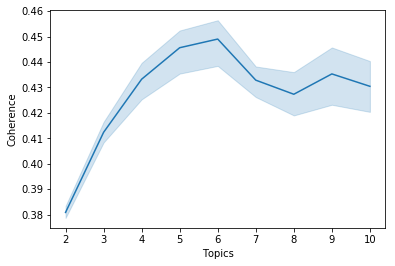

In [364]:
# visualize c_v score vs topics
sns.lineplot(data=df_result_100, x='Topics', y='Coherence');
# best # of topics = 6

In [365]:
# look for the best alpha and beta based on c_v score
df_result_100[df_result_100.Topics == 6].sort_values('Coherence', ascending=False)
# best alpha = 0.1, best beta = 1, achieving 9% improvement over the baseline score

,Validation_Set,Topics,Alpha,Beta,Coherence
266,100% Corpus,6,0.1,1,0.470838
274,100% Corpus,6,symmetric,1,0.466857
269,100% Corpus,6,1,0.1,0.463229
267,100% Corpus,6,0.1,symmetric,0.461911
275,100% Corpus,6,symmetric,symmetric,0.461194
262,100% Corpus,6,0.01,1,0.458310
260,100% Corpus,6,0.01,0.01,0.455759
273,100% Corpus,6,symmetric,0.1,0.454718
265,100% Corpus,6,0.1,0.1,0.453621
270,100% Corpus,6,1,1,0.453319


In [366]:
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=6, 
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha=0.1,
                                             eta=1)

In [368]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [369]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.115279 -0.053642       1        1  25.231611
1      0.041846  0.092680       2        1  24.628040
3      0.077357 -0.020272       3        1  23.639511
2     -0.025974  0.006711       4        1  15.878890
0     -0.096358  0.075424       5        1   8.392106
4     -0.112150 -0.100899       6        1   2.229838, topic_info=    Category        Freq        Term       Total  loglift  logprob
8    Default  338.000000      cheese  338.000000  30.0000  30.0000
25   Default  441.000000       sauce  441.000000  29.0000  29.0000
72   Default   89.000000    parmesan   89.000000  28.0000  28.0000
17   Default  316.000000       olive  316.000000  27.0000  27.0000
106  Default  177.000000       sugar  177.000000  26.0000  26.0000
105  Default  134.000000       brown  134.000000  25.0000  25.0000
10   Default  149.000000         egg  149.000000  24.0000  24.0000
80   Default   44.000000  mozzarella   44.000000  23.0000  23.0000
73   Default   71.000000       pasta   71.000000  22.0000  22.0000
0    Default  209.000000        beef  209.000000  21.0000  21.0000
11   Default   99.000000       flour   99.000000  20.0000  20.0000
23   Default   43.000000      potato   43.000000  19.0000  19.0000
150  Default  100.000000         soy  100.000000  18.0000  18.0000
40   Default   66.000000        milk   66.000000  17.0000  17.0000
32   Default  194.000000      tomato  194.000000  16.0000  16.0000
6    Default   44.000000      carrot   44.000000  15.0000  15.0000
103  Default  178.000000       water  178.000000  14.0000  14.0000
9    Default  109.000000       cream  109.000000  13.0000  13.0000
18   Default  426.000000       onion  426.000000  12.0000  12.0000
7    Default   47.000000     cheddar   47.000000  11.0000  11.0000
216  Default   55.000000      celery   55.000000  10.0000  10.0000
71   Default   74.000000       basil   74.000000   9.0000   9.0000
20   Default  129.000000     parsley  129.000000   8.0000   8.0000
64   Default   67.000000     ketchup   67.000000   7.0000   7.0000
85   Default   33.000000   spaghetti   33.000000   6.0000   6.0000
78   Default   42.000000         jar   42.000000   5.0000   5.0000
178  Default   30.000000        soup   30.000000   4.0000   4.0000
206  Default   98.000000     italian   98.000000   3.0000   3.0000
48   Default  140.000000       lemon  140.000000   2.0000   2.0000
5    Default  227.000000      butter  227.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
862   Topic6    0.796474          tm    5.291892   1.9095  -6.2811
920   Topic6    0.679259         rye    4.675794   1.8741  -6.4403
921   Topic6    0.679259    thousand    4.675794   1.8741  -6.4403
918   Topic6    0.679259      island    4.675794   1.8741  -6.4403
990   Topic6    0.697992     tofutti    4.869224   1.8608  -6.4131
787   Topic6    0.647754      single    4.641388   1.8340  -6.4878
431   Topic6    0.715008    campbell    5.129046   1.8329  -6.3890
6     Topic6    5.757344      carrot   44.250183   1.7639  -4.3030
178   Topic6    3.848000        soup   30.240173   1.7416  -4.7060
574   Topic6    0.932786        bulb    7.042103   1.7818  -6.1231
216   Topic6    4.194004      celery   55.156502   1.2267  -4.6199
4     Topic6    1.655710    bouillon   16.007212   1.5344  -5.5493
176   Topic6    1.942522   condensed   20.479467   1.4478  -5.3895
1     Topic6    1.839321        beer   22.863649   1.2831  -5.4441
109   Topic6    1.723586       chunk   20.831068   1.3112  -5.5091
103   Topic6    5.659728       water  178.996140   0.3493  -4.3201
40    Topic6    3.089707        milk   66.459167   0.7347  -4.9254
18    Topic6    6.370718       onion  426.522461  -0.4007  -4.2018
37    Topic6    2.409114      turkey   59.078724   0.6036  -5.1743
884   Topic6    1.056644  matchstick    9.089935   1.6512  -5.9984
11    Topic6    2.545116       flour   99

In [371]:
# Print the keyword in the 10 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.094*"cheese" + 0.030*"parmesan" + 0.025*"mozzarella" + 0.025*"sauce" + '
  '0.024*"garlic" + 0.022*"tomato" + 0.021*"salt" + 0.019*"egg" + '
  '0.018*"onion" + 0.018*"pasta"'),
 (1,
  '0.065*"pepper" + 0.046*"olive" + 0.043*"oil" + 0.039*"salt" + '
  '0.030*"garlic" + 0.022*"black" + 0.021*"red" + 0.020*"lemon" + '
  '0.018*"tomato" + 0.015*"onion"'),
 (2,
  '0.046*"pepper" + 0.042*"cheese" + 0.035*"salt" + 0.026*"beef" + 0.022*"egg" '
  '+ 0.021*"onion" + 0.021*"black" + 0.019*"butter" + 0.019*"flour" + '
  '0.017*"cream"'),
 (3,
  '0.065*"pepper" + 0.051*"salt" + 0.035*"black" + 0.030*"garlic" + '
  '0.027*"oil" + 0.026*"onion" + 0.019*"butter" + 0.015*"cayenne" + '
  '0.015*"pork" + 0.014*"powder"'),
 (4,
  '0.019*"potato" + 0.015*"onion" + 0.014*"carrot" + 0.013*"water" + '
  '0.011*"crust" + 0.010*"celery" + 0.010*"pie" + 0.009*"soup" + '
  '0.009*"pastry" + 0.008*"salt"'),
 (5,
  '0.060*"sauce" + 0.046*"pepper" + 0.032*"sugar" + 0.029*"salt" + '
  '0.029*"garlic" + 0.02

In [492]:
# create a df to show lda matrix
lda_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

for _ in range(len(doc_lda)):
    lda_dict[0].append(0)
    lda_dict[1].append(0)
    lda_dict[2].append(0)
    lda_dict[3].append(0)
    lda_dict[4].append(0)
    lda_dict[5].append(0)

# create a df filled with 0
lda_matrix = pd.DataFrame(lda_dict)

# fill the prop of topic for each row
for i, row in enumerate(doc_lda):
    for j, (topic, prop_topic) in enumerate(row):
        lda_matrix.loc[i, topic] = prop_topic

In [493]:
lda_matrix.head()

,0,1,2,3,4,5
0,0.0,0.139167,0.850977,0.000000,0.0,0.000000
1,0.0,0.000000,0.000000,0.952821,0.0,0.000000
2,0.0,0.000000,0.960303,0.000000,0.0,0.000000
3,0.0,0.767655,0.000000,0.000000,0.0,0.210831
4,0.0,0.000000,0.952817,0.000000,0.0,0.000000


In [494]:
# add recipe name
lda_matrix = lda_matrix.merge(df_lda, left_index=True, right_index=True, how='inner')

# set title as index
lda_matrix.set_index('title', inplace=True)

lda_matrix.head()

,0,1,2,3,4,5,ingredient
title,,,,,,,
A Scotsmans Shepherd Pie,0.0,0.139167,0.850977,0.000000,0.0,0.000000,boiled potato sour cream cream cheese butter s...
A Simply Perfect Roast Turkey,0.0,0.000000,0.000000,0.952821,0.0,0.000000,turkey unsalted butter softened salt black pep...
Absolute Best Liver And Onions,0.0,0.000000,0.960303,0.000000,0.0,0.000000,beef liver milk needed butter vidalia onion ri...
Accidental Fish,0.0,0.767655,0.000000,0.000000,0.0,0.210831,mahi mahi olive oil salted butter garlic lemon...
Actually Delicious Turkey Burgers,0.0,0.000000,0.952817,0.000000,0.0,0.000000,turkey bread onion egg white parsley garlic sa...


In [495]:
# assign topic names using my judgement
lda_matrix[lda_matrix[0] > 0.8][:10]
# topic 0 looks like baked dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
Alysias Basic Meat Lasagna,0.981199,0.0,0.0,0.000000,0.0,0.0,beef garlic powder jar sausage spaghetti sauce...
American Lasagna,0.978808,0.0,0.0,0.000000,0.0,0.0,beef onion garlic basil oregano brown sugar sa...
Artichoke Spinach Lasagna,0.839670,0.0,0.0,0.141807,0.0,0.0,spray uncooked lasagna noodle onion garlic veg...
Baked Eggplant Parmesan,0.974484,0.0,0.0,0.000000,0.0,0.0,eggplant salt needed italian bread parmesan ch...
Baked Orange Roughy Italian Style,0.963222,0.0,0.0,0.000000,0.0,0.0,italian bread parmesan cheese romano cheese ga...
Baked Spaghetti,0.971585,0.0,0.0,0.000000,0.0,0.0,spaghetti beef onion jar meatless spaghetti sa...
Baked Ziti I,0.967944,0.0,0.0,0.000000,0.0,0.0,ziti pasta onion beef jar spaghetti sauce prov...
Baked Ziti Iii,0.969876,0.0,0.0,0.000000,0.0,0.0,ziti pasta beef onion jar spaghetti sauce prov...
Baked Ziti Iv,0.979669,0.0,0.0,0.000000,0.0,0.0,ziti pasta olive oil onion rosemary garlic bee...


In [496]:
lda_matrix[lda_matrix[1] > 0.8][:10]
# topic 1 looks like seafood dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
Bacon Risotto,0.00000,0.965743,0.000000,0.000000,0.000000,0.000000,bacon chicken stock butter onion garlic arbori...
Baked Halibut Steaks,0.00000,0.965745,0.000000,0.000000,0.000000,0.000000,olive oil zucchini onion garlic tomato basil s...
Baked Salmon Ii,0.00000,0.960311,0.000000,0.000000,0.000000,0.000000,garlic light olive oil basil salt black pepper...
Balsamic Baked Tilapia,0.00000,0.973111,0.000000,0.000000,0.000000,0.000000,olive oil yellow onion red bell pepper balsami...
Barbarian Beef,0.00000,0.923459,0.000000,0.000000,0.000000,0.056126,round steak salt natural hardwood lump charcoa...
Basic Microwave Risotto,0.00000,0.806072,0.000000,0.162170,0.000000,0.000000,butter garlic onion vegetable broth uncooked a...
Bbq Ny Strip,0.00000,0.804510,0.000000,0.000000,0.000000,0.173978,extra virgin olive oil worcestershire sauce ga...
Blackened Tuna,0.01316,0.934199,0.013161,0.013161,0.013159,0.013160,tuna steak cajun seasoning olive oil butter
Bow Ties With Sausage Tomatoes And Cream,0.00000,0.976847,0.000000,0.000000,0.000000,0.000000,bow tie pasta olive oil sweet italian sausage ...


In [497]:
lda_matrix[lda_matrix[2] > 0.8][:10]
# topic 2 looks like cheese dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
A Scotsmans Shepherd Pie,0.000000,0.139167,0.850977,0.000000,0.00000,0.00000,boiled potato sour cream cream cheese butter s...
Absolute Best Liver And Onions,0.000000,0.000000,0.960303,0.000000,0.00000,0.00000,beef liver milk needed butter vidalia onion ri...
Actually Delicious Turkey Burgers,0.000000,0.000000,0.952817,0.000000,0.00000,0.00000,turkey bread onion egg white parsley garlic sa...
Awesome Grilled Cheese Sandwiches,0.021744,0.021741,0.891293,0.021742,0.02174,0.02174,bread butter cheddar cheese
Baked Cod With Boursin Herb Cheese,0.161954,0.000000,0.812397,0.000000,0.00000,0.00000,butter cod boursin cheese herb room temperatur...
Baked Flounder With Panko And Parmesan,0.000000,0.000000,0.861600,0.100655,0.00000,0.00000,flounder butter parmesan cheese panko bread sa...
Baked Haddock,0.011634,0.011632,0.941834,0.011640,0.01163,0.01163,milk salt bread parmesan cheese thyme haddock ...
Baked Macaroni And Cheese,0.011631,0.011630,0.941849,0.011630,0.01163,0.01163,macaroni egg milk butter cheddar cheese salt p...
Baked Parmesan Tilapia,0.090337,0.000000,0.891958,0.000000,0.00000,0.00000,spray milk ranch dressing flour bread parmesan...


In [499]:
lda_matrix[lda_matrix[3] > 0.8][:10]
# topic 3 looks like pork dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
A Simply Perfect Roast Turkey,0.0,0.0,0.0,0.952821,0.0,0.000000,turkey unsalted butter softened salt black pep...
Alaska Salmon Bake With Pecan Crunch Coating,0.0,0.0,0.0,0.956885,0.0,0.000000,dijon mustard butter honey bread pecan parsley...
Apple Cider Sauce And Pork Loin Chops,0.0,0.0,0.0,0.814076,0.0,0.164412,olive oil pork loin seasoning salt black peppe...
Apple Glazed Pork Tenderloin,0.0,0.0,0.0,0.974482,0.0,0.000000,olive oil pork tenderloin salt black pepper pa...
Awesome Red Wine Pot Roast,0.0,0.0,0.0,0.976843,0.0,0.000000,beef roast flour canola oil water red wine bas...
Bacon Wrapped Cranberry Walnut Pork,0.0,0.0,0.0,0.983105,0.0,0.000000,pork tenderloin salt black pepper dijon mustar...
Baked Dijon Salmon,0.0,0.0,0.0,0.960307,0.0,0.000000,butter dijon mustard honey bread pecan parsley...
Balsamic Roasted Pork Loin,0.0,0.0,0.0,0.952821,0.0,0.000000,steak seasoning rub balsamic vinegar olive oil...
Beans And Belly,0.0,0.0,0.0,0.989032,0.0,0.000000,pork belly pork belly skin salt black pepper c...


In [509]:
lda_matrix[lda_matrix[4] > 0.8][:10]
# topic 4 looks like beef dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
Campbellsr Slow Cooker Savory Pot Roast,0.000000,0.000000,0.000000,0.000000,0.973110,0.000000,campbell condensed cream mushroom soup request...
Chef Johns Corned Beef And Cabbage,0.000000,0.000000,0.000000,0.000000,0.965744,0.000000,corned beef brisket spice water onion carrot c...
Kimchi Corned Beef,0.000000,0.000000,0.000000,0.000000,0.969868,0.000000,ready cook corned beef jar kimchi cold water n...
Lobster Tails Steamed In Beer,0.038467,0.038470,0.038471,0.038472,0.807647,0.038471,lobster tail beer
Pot Roast In Foil,0.010420,0.010419,0.010421,0.010418,0.947904,0.010418,bottom round condensed cream mushroom soup oni...
Slow Cooker Corned Beef And Cabbage,0.000000,0.000000,0.000000,0.000000,0.963228,0.000000,carrot matchstick red potato onion sized water...
Turkey Pot Pie Ii,0.000000,0.000000,0.000000,0.000000,0.960309,0.000000,pastry double crust pie turkey vegetable onion...


In [512]:
lda_matrix[lda_matrix[5] > 0.8][:10]
# topic 5 looks like bbq dishes

,0,1,2,3,4,5,ingredient
title,,,,,,,
All American Roast Beef,0.010419,0.010419,0.010420,0.010421,0.010418,0.947903,beef eye round roast salt garlic powder black ...
Amazing Ribs,0.000000,0.000000,0.000000,0.000000,0.000000,0.963223,pork back rib black pepper salt red pepper bar...
Apricot Brown Sugar Ham,0.011631,0.011631,0.011632,0.011633,0.011632,0.941842,spiral ham brown sugar apricot jam mustard powder
Asian Beef Skewers,0.000000,0.000000,0.000000,0.000000,0.000000,0.967945,hoisin sauce sherry soy sauce barbeque sauce g...
Asian Pork Tenderloin,0.000000,0.000000,0.000000,0.000000,0.000000,0.974486,lite soy sauce sesame oil worcestershire sauce...
Asian Salmon,0.000000,0.111819,0.000000,0.000000,0.000000,0.869659,salmon skin olive oil rice vinegar soy sauce b...
Awesome Korean Steak,0.000000,0.000000,0.000000,0.000000,0.000000,0.971584,scotch eye steak soy sauce white sugar sesame ...
Awesome Spicy Beef Kabobs Or Haitian Voodoo Sticks,0.000000,0.000000,0.000000,0.000000,0.000000,0.971583,beef bouillon granule water garlic cayenne pep...
Baby Back Ribs,0.017859,0.017858,0.017858,0.017861,0.017859,0.910705,pork back rib barbecue sauce


In [520]:
# drop ingredient  
lda_matrix.drop('ingredient', axis=1, inplace=True)

# change column name
lda_matrix.columns = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

lda_matrix.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
title,,,,,,
A Scotsmans Shepherd Pie,0.0,0.139167,0.850977,0.000000,0.0,0.000000
A Simply Perfect Roast Turkey,0.0,0.000000,0.000000,0.952821,0.0,0.000000
Absolute Best Liver And Onions,0.0,0.000000,0.960303,0.000000,0.0,0.000000
Accidental Fish,0.0,0.767655,0.000000,0.000000,0.0,0.210831
Actually Delicious Turkey Burgers,0.0,0.000000,0.952817,0.000000,0.0,0.000000


In [519]:
# save lda_matrix
lda_matrix.to_csv('lda_matrix.csv')

In [521]:
lda_matrix.index

Index(['A Scotsmans Shepherd Pie', 'A Simply Perfect Roast Turkey',
       'Absolute Best Liver And Onions', 'Accidental Fish',
       'Actually Delicious Turkey Burgers',
       'Alaska Salmon Bake With Pecan Crunch Coating',
       'All American Burger Dog', 'All American Roast Beef', 'Alla Checca',
       'Almond Crusted Tilapia',
       ...
       'Vietnamese Sandwich', 'Walnut Crusted Chicken Breast',
       'Wiener Schnitzel', 'Wienerschnitzel', 'Wonderful Short Ribs',
       'Worlds Best Lasagna', 'Worlds Fastest Meatballs',
       'Yummy Lemon Salmon Burgers', 'Zippy Shepherds Pie',
       'Zucchini Patties'],
      dtype='object', name='title', length=958)

References: 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0